# Practical Data Visualization with Python - Part 4: Library Deep-Dive (Plotly)

## Setup

In [1]:
%%capture
# capturing above because there are a few useless warnings that might pop up, version-depending

# basic packages:
import numpy as np
import pandas as pd
import datetime

# packages for viz:
# plotly express
import plotly_express as px
# matplotlib
import matplotlib.pyplot as plt
# seaborn and default seaborn settings set for matplot lib charts
import seaborn as sns; sns.set()
# base plotly packages
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import plot, iplot, init_notebook_mode
from plotly.subplots import make_subplots
# turns on plotly notebook mode
init_notebook_mode()
from plotly import graph_objs as go
# altair
import altair as alt
# turns on altair renderer -- jlab is default
alt.renderers.enable('jupyterlab')
# bokeh
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
# plotnine
from plotnine import *

In [2]:
# there are a few warnings I want to silence throughout that are due to unimportant np deprecations 
np.warnings.filterwarnings('ignore')

In [3]:
# store the datetime of the most recent running of this notebook as a form of a log
most_recent_run_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
f"This notebook was last executed on {most_recent_run_datetime}"

'This notebook was last executed on 2019-08-06 10:53'

In [4]:
# pulling in our main data; for more info on the data, see the "data_prep_nb.ipynb" file
main_df = pd.read_csv(filepath_or_buffer='../data/jan_and_dec_17_acqs.csv')

# taking a peek at our data
main_df.head()

,loan_id,orig_chn,seller_name,orig_rt,orig_amt,orig_trm,orig_dte,frst_dte,oltv,ocltv,...,occ_stat,state,zip_3,mi_pct,product_type,cscore_c,mi_type,relocation_flg,cscore_min,orig_val
0,100020736692,B,"CALIBER HOME LOANS, INC.",4.875,492000,360,12/2017,02/2018,75,75,...,I,CA,920,NaN,FRM,NaN,NaN,N,757.0,656000.000000
1,100036136334,R,OTHER,2.750,190000,180,12/2017,01/2018,67,67,...,P,MD,206,NaN,FRM,798.0,NaN,N,797.0,283582.089552
2,100043912941,R,OTHER,4.125,68000,360,12/2017,02/2018,66,66,...,P,OH,432,NaN,FRM,NaN,NaN,N,804.0,103030.303030
3,100057175226,R,OTHER,4.990,71000,360,12/2017,02/2018,95,95,...,P,NC,278,30.0,FRM,NaN,1.0,N,696.0,74736.842105
4,100060715643,R,OTHER,4.500,180000,360,12/2017,02/2018,75,75,...,I,WA,983,NaN,FRM,NaN,NaN,N,726.0,240000.000000


In [5]:
# pre-visualization data prep:
# creating a df with just the january origination volume of our top 10 lenders by volume in that month

# filtering to just january acquisitions and dropping "OTHER" sellers
jan_originations_only = main_df.loc[(main_df['orig_dte'] == '01/2017') & (main_df['seller_name'] != 'OTHER'),:]

# getting the top 3 lenders by volume
top_3_lenders = (
    jan_originations_only
    .groupby('seller_name')
    .size()
    .reset_index(name='counts')
    .sort_values('counts', ascending=False)
    .head(3)
)['seller_name']

# making a df of just the records from the top 3 lenders by volume, keeping just the needed columns: seller name and FICO
top_3_lenders_jan_origs_df = jan_originations_only.loc[main_df['seller_name'].isin(top_3_lenders),['seller_name','cscore_min']]

# inspecting the data we'll be working with for this example
top_3_lenders_jan_origs_df.head()

,seller_name,cscore_min
2803,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",724.0
3208,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",744.0
8514,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",695.0
10496,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",738.0
10788,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",701.0


## Library Deep-Dive (Plotly)

Having now covered some of the more theoretical components of a robust data visualization toolkit, explored the menu of package options from which one can choose, and gone through a few examples of statistical visualization problems one might face on the job, it seemed apposite to round out this material with a deep-dive into a particular package. There are a few reasons for doing this with [Plotly](https://plot.ly/python/) specifically:

1. Popularity of Plotly
    - Plotly is a popular suite of visualization options for python and R uses alike. 
2. Synergies between Plotly and Dash
    - Plotly plays nicely with [Dash](https://plot.ly/dash/)--a popular python web app framework.
3. Reinforces a Key Skill: Hunting Through Documentation
    - Plotly is a vast library with documentation that varies in degrees of ease of use, so it is an excellent package with which to hone one's skills at navigating documentation to find the answer you need. 
    
Plotly is, as of March of 2019, more than one library. I'm simplifying a bit here for the sake of concision, but there are essentially two main variants of Plotly visualizations: base Plotly, and [Plotly Express](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d). We'll dive into both here shortly, but suffice it to say that the names do a decent job of explaining what differentiates both packages: base Plotly allows the user a high degree of customizability in crafting a wide array of interactive javascript-based visualizations. Plotly Express takes much of the functionality of base Plotly, but simplifies the API a great deal at the cost of sacrificing some small degree of customizability.

Now, we'll jump into examples for both.

### Plotly Express.

In describing Plotly Express, I don't think one can do better than the [announcement post](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d) for the package:

> Plotly Express is a new high-level Python visualization library: it’s a wrapper for Plotly.py that exposes a simple syntax for complex charts. Inspired by Seaborn and ggplot2, it was specifically designed to have a terse, consistent and easy-to-learn API: with just a single import, you can make richly interactive plots in just a single function call, including faceting, maps, animations, and trendlines.

My personal take then, is that Plotly Express is, simply put, Plotly's competitor to [Seaborn](https://seaborn.pydata.org/). It is particularly well-suited for visualization problems where the chart / mark-type you need isn't very niche. Differently put, if you are looking to build a very particular type of choropleth map, for example, stick with base Plotly (or some other package), as we will later in this material. If, on the other hand, you want to make a bar chart, scatter plot, etc. (see a fuller yet not exhaustive [list of potential chart types here](https://plot.ly/python/plotly-express/)), Plotly Express is a great tool to leverage. If you are looking for more of a walkthrough to Plotly Express, [see here](https://nbviewer.jupyter.org/github/plotly/plotly_express/blob/gh-pages/walkthrough.ipynb?source=post_page---------------------------) for that type of documentation as well. Also, note that Plotly, like most packages, is constantly evolving. As one example of this, a [recently released updated for Plotly -- Plotly 4.0](https://medium.com/@plotlygraphs/plotly-py-4-0-is-here-offline-only-express-first-displayable-anywhere-fc444e5659ee) -- will impact how we go about updating things like Plotly Express layouts, etc. As such, it pays to keep an ear to the ground with respect to package updates and best practices. 

Finally, note that if you are trying to trouble-shoot or explore with Plotly Express, my preferred source of help is always the official [Plotly Express documentation](https://www.plotly.express/plotly_express/). If the docs fail you, you can of course always try `?name_of_plotly_function_here`, and last but certainly the most hacky of solutions: you can make up parameters within the function that you know don't exist, as sometimes the error traceback that will result can yield yelpful insights about allowable values, etc.
 
Now, let's jump into a deeper exploration of Plotly Express by diving into the details of the facetted histogram we briefly went over early in this material, dissecting the various components, and also improving on / [updating it](https://plot.ly/python/creating-and-updating-figures/
).

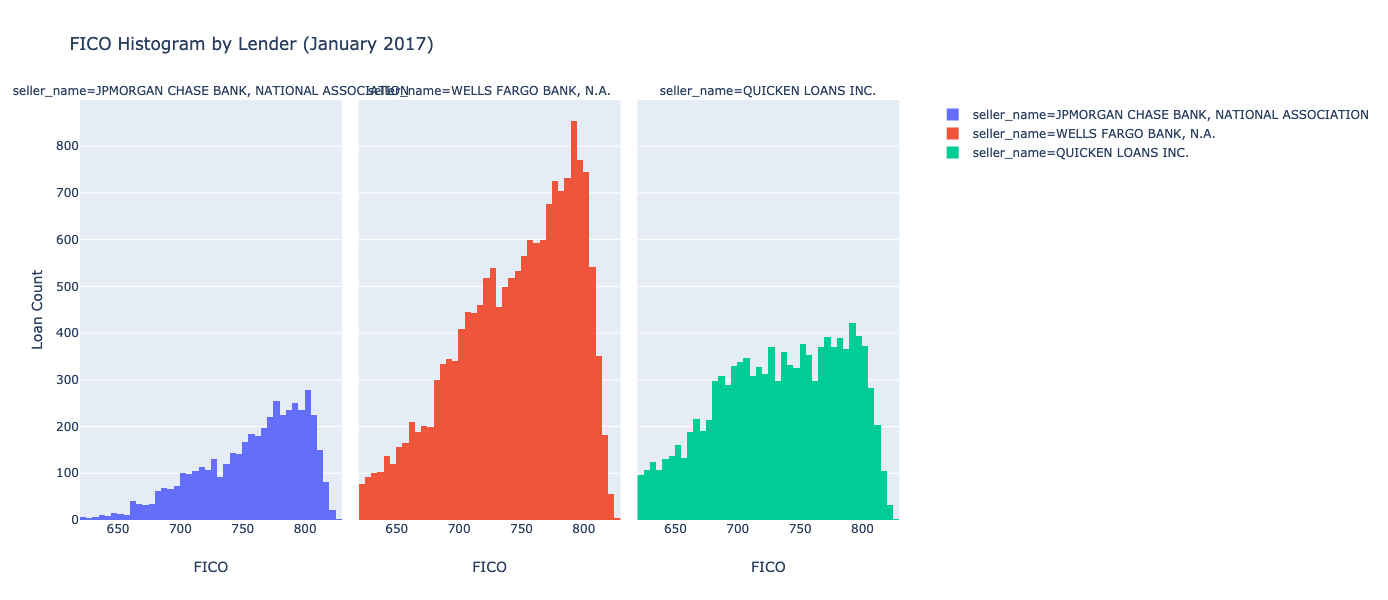

In [6]:
# dissection of a histogram with Plotly Express
lender_fico_hist = px.histogram(
    # data frame containing the data for this plot
    data_frame = top_3_lenders_jan_origs_df,
    # variable to be plotted on the x-axis
    x = 'cscore_min',
    # variable to be used to determine color of the bars
    color = 'seller_name',
    # variable to split on for facets; in this case, we'll facet across columns
    facet_col = 'seller_name',
    # number of bins to use--somewhat arbitrary; google "histogram binning bias" to learn more
    nbins = 100,
    # title for the entire chart
    title = "FICO Histogram by Lender (January 2017)",
    # figure output height and width in pixels; will autoscale if just given 1 value 
    # note that while this exact size has worked well for us previously, it appears scrunched below
    # the reason for this is that we're not hiding the legend now, which messes with spacing
    height = 600,
    width = 900
)

# note that what we add on to the plot here with "update" statements is NOT available in the base px.histogram parameters
(lender_fico_hist
 # change x-axis label
 .update_xaxes(title = "FICO")
 # change y-axis label and specify we only want one axis labeled (the one in row 1 and col 1)
 # the row, col params were hard to find at first, but this explains it: https://github.com/plotly/plotly_express/issues/128
 .update_yaxes(title = "Loan Count", row=1, col=1)
)

**Note:** the best place to get started (aside from googling the exact question you have) when looking for how to get an API like plotly express to do what you want is to look at the possible parameters of relevant functions / methods to see what options they take. For example, in the above viz. we ensure that the y-axis label only appears once on the facetted chart, and this is thanks to the `row` and `col` arguments. If you were looking for this functionality but didn't what arguments to use, the best place to start hunting would be to call `?lender_fico_hist.update_xaxes`. We'll dive into some further examples of these kinds of trouble-shooting techniques below.

While we've made a few improvements to the chart--axis labels, title, etc.--I still don't like the legend location (which as mentioned above is messing with the skewed sizing of the entire chart) or the facet labels. How would I go about fixing this? Well... if we go to [the documentation for Plotly Express barcharts](https://www.plotly.express/plotly_express/#plotly_express.bar), we don't see anything about legends. Now what? 

We'll, I would start by digging into the anatomy of our specific chart by calling `?lender_fico_hist`, and we'll begin to see what lies beneath the Plotly Express API. We'll see Some basic information about the object, for example: it is of type "Express Figure", and under "Init docstring:" we start to see how it is made.

![](../media/inspecting_top_of_px_figure.jpg)

---

Then, if we look a bit further down in the output, we'll start to see the two main components that make up a Plotly figure (both Express, and otherwise): the `data` and the `layout` options. 

![](../media/inspecting_parameters_px_figure.jpg)

---

Everything listed under `layout` ... `Supporting dict properties:` let's you see all of the layout parameters that could be callable! There are a lot of them, for sure. Remeber, we're looking to learn about how to mess with the legend, so we scroll through these properties until we get to `legend`, as shown below. 

![](../media/inspecting_legend_param_px_figure.jpg)

---

From this, we can tell that there is a legend parameter that is a part of this figure's layout and that is callable as a dictionnary... but what value within that dictionnary controls the legend's location? Well, for that, I kid you not, the most tried and true method I have discovered is to guess, and read the error traceback. For example, I might write the chunk of code below...

![](../media/purposefully_breaking_pxcode_layout.jpg)

---

Which will ultimately throw an error containing, among other things this traceback here:

![](../media/px_error_layout_traceback.jpg)

Eureka! A list of parameteres that our legend dictionnary can take, a few of which have to deal with the legend's location. We can thus apply this guess-and-check method to fix the chart as we'd like, arriving at the following layout updates below.

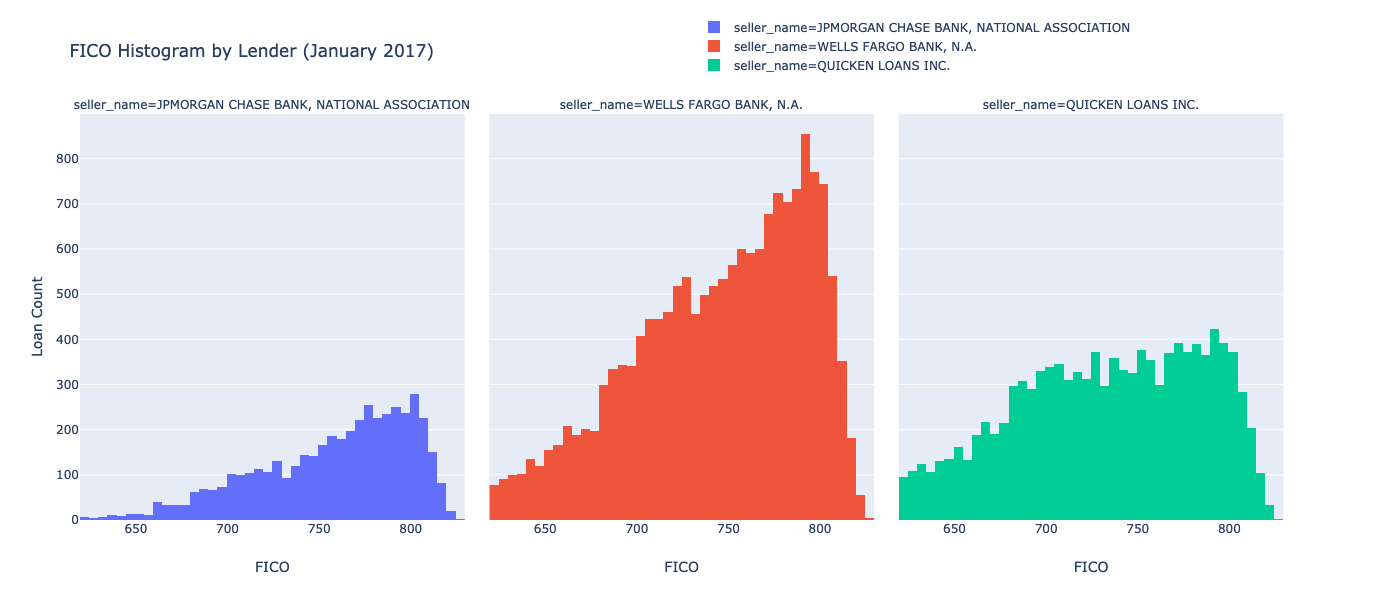

In [7]:
# now that we've found the right layout and legend parameters, we have what we need to move the legend where we want it:
(lender_fico_hist
 # change the layout's location
 .update(
     layout = dict(
         legend = dict(
             # pick the x and y coords manually (bounded between [-2,3])
             x = 0.5,
             y = 1.25
         )
     )
 )
)

After all of that work, howeover, our chart labels still don't look as we'd like. As it turns out, this is one of the areas where the Plotly API, no matter how deep we go in the docstrings, doesn't afford us the flexibility we might want. As such, in order to clean up the labels for both the facets and the color legend, we'll need to transform our starting data slight--something that is actually quite common when making a custom viz. This just goes to show that **sometimes it is better to transform your data to suit the API, than to force the API to do something it wasn't designed to do.**

In [8]:
# making a copy of our df that we'll use just for the purpose of this viz
vizready_top_3_lender_df = top_3_lenders_jan_origs_df

# defining a function that we'll apply over our existing df to rename the banks to shorter labels
def big_three_bank_labeler (row):
   if row['seller_name'] == 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION':
      return 'JPMorgan'
   if row['seller_name'] == 'WELLS FARGO BANK, N.A.':
      return 'Wells'
   if row['seller_name'] == 'QUICKEN LOANS INC.':
      return 'Quicken'

# applying our custom labeling function
vizready_top_3_lender_df['Lender'] = vizready_top_3_lender_df.apply(big_three_bank_labeler, axis=1)

# inspecting the results
vizready_top_3_lender_df.head()

,seller_name,cscore_min,Lender
2803,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",724.0,JPMorgan
3208,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",744.0,JPMorgan
8514,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",695.0,JPMorgan
10496,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",738.0,JPMorgan
10788,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",701.0,JPMorgan


Now that we have transformed our data to suit the constraints of our API, after having throughougly explored the various options and paramters with which we can work, let's dive into the creation of the final viz. 

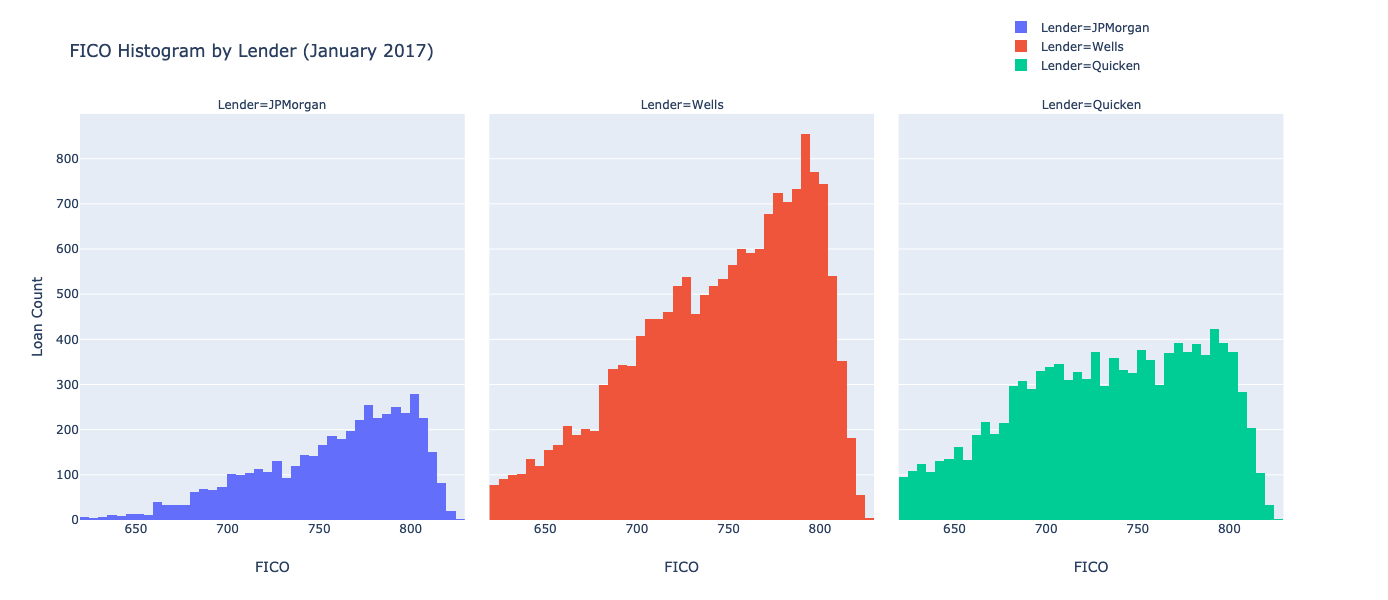

In [9]:
# final histogram with all parameters and layout options we want integrated
lender_fico_hist = (
    px.histogram(
    # data frame containing the data for this plot
    data_frame = vizready_top_3_lender_df,
    # variable to be plotted on the x-axis
    x = 'cscore_min',
    # variable to be used to determine color of the bars
    color = 'Lender',
    # variable to split on for facets; in this case, we'll facet across columns
    facet_col = 'Lender',
    # number of bins to use--somewhat arbitrary; google "histogram binning bias" to learn more
    nbins = 100,
    # title for the entire chart
    title = "FICO Histogram by Lender (January 2017)",
    # figure output height and width in pixels
    height = 600,
    width = 900
    )
    # making edits to layout
    # specifying x-axis label
    .update_xaxes(
        title = "FICO"
    )
    # specifiying y-axis label and ensuring we only show the 1st axis label
    .update_yaxes(
        title = "Loan Count",
        row=1, 
        col=1
    )
    # specifying location of the legend (under general layout)
    .update(
     layout = dict(
         legend = dict(
             # pick the x and y coords manually (bounded between [-2,3])
             x = 0.75,
             y = 1.25
         )
     )
 )
)

# calling the figure so it will display inline
# we can also save out the png as shown above with plotly.io
lender_fico_hist

After all of this, one final thought you might have could be: isn't it redundant to have the facet labels say the exact same thing as the legend? Yes! The tough part about that is that there simply isn't a parameter or an update method as of yet that exists to deal with hiding these labels. This isn't something that is intuitive, either. Rather, after a long journey through [the docs](https://plot.ly/python/reference/), I eventually went with the nuclear option (not recommended) and simply tweeted at the head of product for Plotly about this, and [he very graciously responded](https://twitter.com/nicolaskruchten/status/1153472636745396224?s=20), as shown below. As Nicolas shows us, the only way to deal with this is by dropping all annotations (for now; an update method is in the works). 

![](../media/tweet_at_plotly_devs_response.jpg)

The lesson here is not to tweet at package devs whenever you encouter a problem, but rather to build a community around you to whom you can turn for answers when you hit a particularly hard problem.

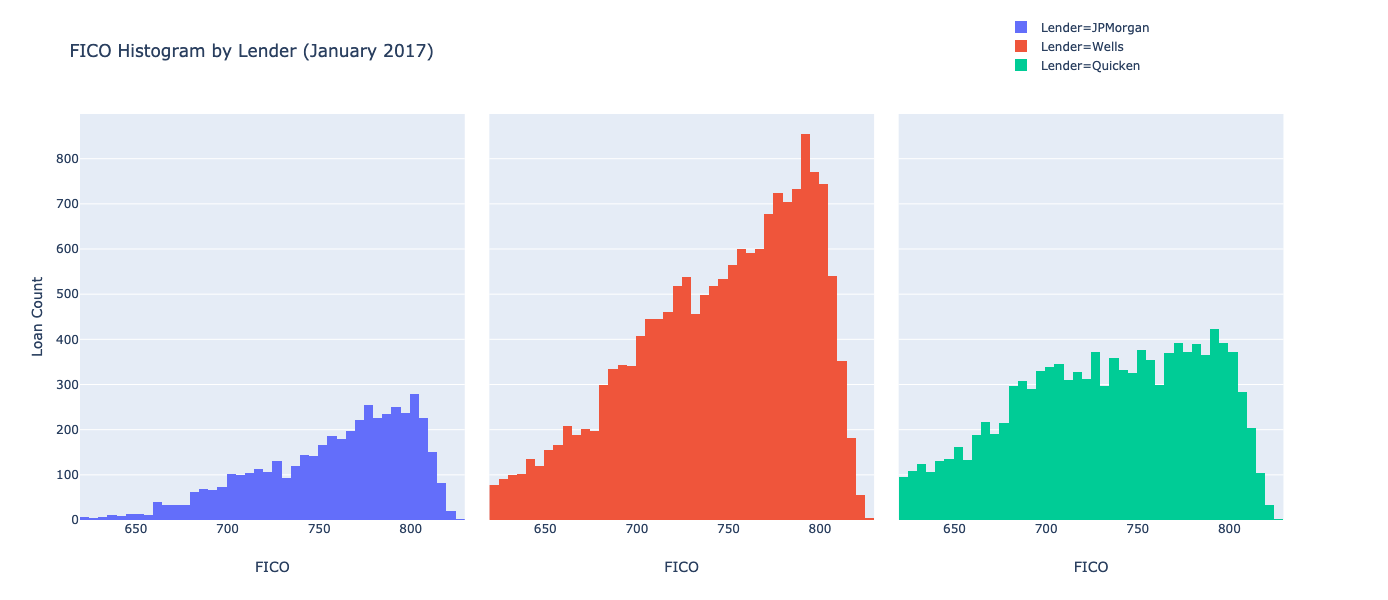

In [10]:
# implementing fix recommended by Nicolas to drop facet labels
lender_fico_hist.layout.annotations = []

# displaying the final draft of our output
lender_fico_hist

In [11]:
# the figure can also be saved out in html format, as can all Plotlys...
# using the plotly.offline function "plot"
plot(
    figure_or_data = lender_fico_hist, 
    filename="../media/lender_fico_hist.html", 
    auto_open=False
);

### Base Plotly.

Now that we've explored the wonders of Plotly Express, a logical question would be: why bother returning to base Plotly given all the functionality of Plotly Express? Well, there are two mains answers to that question:

- Access to certain figure types that are non achievable (yet, to my knowledge) with Plotly Express
    - Some figure varieties are so domain-specific or otherwise niche that there simply isn't yet a Plotly Express API built to produce that particular variety of viz, for example, the [quiver plot](https://plot.ly/python/v3/quiver-plots/)
    - The example we'll go over pertaining to this justification entails exploring the creation of [distribution plots (aka distplots)](https://plot.ly/python/distplot/) with Plotly's [figure factory](https://plot.ly/python/figure-factory-subplots/#plotlys-figure-factory-module), where chart types go prior to being integrated into the broader Plotly.js library of plot types. 
- Less abstraction in syntax = more granular control over all details of the viz
    - Think about how, as we went through the Plotly Express examples, we had to dig into the skeletal structure of the plot (Data and Layout) in order to find what parameters we might be able to pass to an `update()` method call to get our desired plot. With base plotly, we start out at this level of detail, which is both more work, but also more all-encompassing from the get-go. 
    - The example we'll go over pertaining to this justification entails creating a custom heatmap.


**Note of Clarification:** When mentioning "base Plotly", I am referring to everything in the Plotly ecosystem that is not Plotly Express. Generally, this entails Plotly ["Graphical Objects" (aka "Go")](https://plot.ly/python/creating-and-updating-figures/#figures-as-graph-objects) and the aforementioned Plotly ["Figure Factory" (aka "FF")](https://plot.ly/python/figure-factory-subplots/). If Plotly Express is mostly used as the quickest way to interact with Plotly visualizations, you can think of Go as the largest overarching granular framework for making most any plot type with Plotly, and Figure Factory as a more experimental branch of the Plotly API, as previously described. 

With all that context in mind, let's jump into exploring these aforementioned example use cases for base Plotly, below.

In [12]:
# building a distribution plot of FICO distributions by lender using the Plotly figure factory

# transforming the data in the manner that the ff API prefers
# making one vector for Lender's each FICO distribution, downsampling (5%) for speed purposes, and dropping any NAs
jpm_fico_distro = (
    vizready_top_3_lender_df
    .loc[vizready_top_3_lender_df['Lender']=='JPMorgan','cscore_min']
    .dropna()
    .sample(frac = 0.05)
)
wells_fico_distro = (
    vizready_top_3_lender_df
    .loc[vizready_top_3_lender_df['Lender']=='Wells','cscore_min']
    .dropna()
    .sample(frac = 0.05)
)
quick_fico_distro = (
    vizready_top_3_lender_df
    .loc[vizready_top_3_lender_df['Lender']=='Quicken','cscore_min']
    .dropna()
    .sample(frac = 0.05)
)

# grouping the data into an array, per the API's preferences
fico_distro_data = [jpm_fico_distro, wells_fico_distro, quick_fico_distro]
# adding labels positionally, again per the API's preferences
group_labels = ['JPM', 'Wells', 'Quicken']

# create distplot with a PDF curve and rug plot
lender_fico_distplot = (
    ff.create_distplot(
        # array of data
        hist_data = fico_distro_data, 
        # positional labels to match to data array
        group_labels = group_labels, 
        # tell Plotly what kind of curve you want (kernel density)
        curve_type = 'kde',
        # just going to go with base colors, but you can get fancier if you want
        colors = None,
        # pick to show what of the 3 distplot components to display
        show_hist = False,
        show_curve = True,
        show_rug = True
    )
    # specifiying x-axis label
    .update_xaxes(title = "FICO")
    # specifiying y-axis label
    .update_yaxes(title = "Concentration")
    # adding a title to the chart
    .update(
     layout = dict(
         title = dict(
             text = "Distribution Plot of FICO by Lender"
         )
     )
 )
)

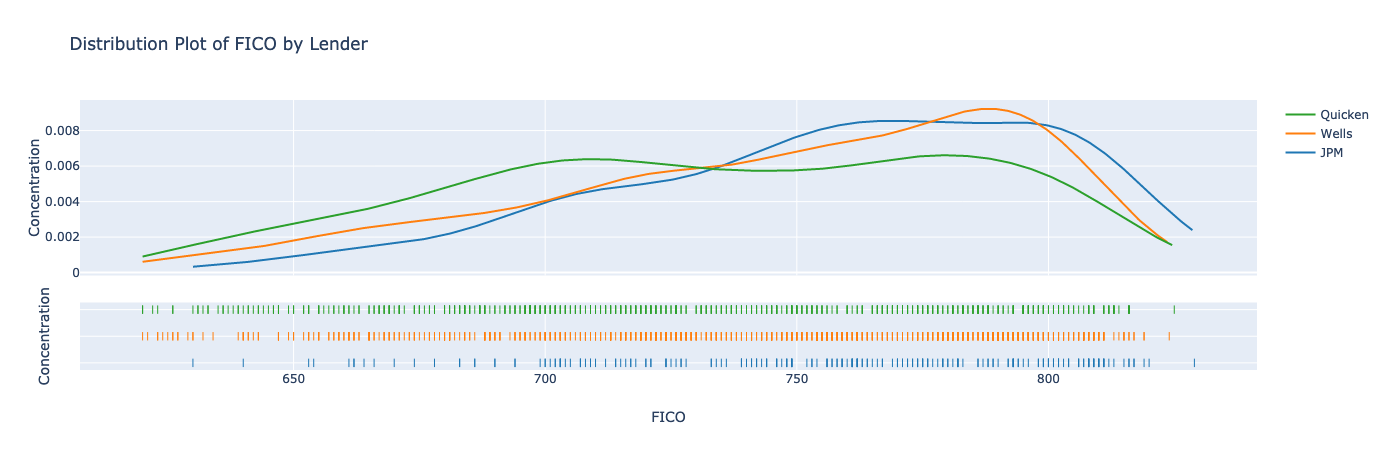

In [13]:
# displays the interactive version of the distplot in the notebook
iplot(
    figure_or_data = lender_fico_distplot
)

In [14]:
# saves out the html version of the figure as we've seen 
plot(
    figure_or_data = lender_fico_distplot, 
    filename="../media/lender_fico_distplot.html", 
    auto_open=False
);

Now that we've seen an example of the utility of base Plotly in buiding niche chart types via Plotly's Figure Factory, let's move to the other main use case of base Plotly: very granular control over your visualization. For this, we'll turn to Plotly Go figures. 

In this example we'll be able to see most clearly how Plotly works on the back end, creating a `figure` by combining a dictionnary specifying what `data` are to be included, and what `layout` is to be used. 

Let's imagine a business scenario where we want to see how much UPB (origination amount) we have concentrated across different LTV and FICO cohorts. Do we have large pockets of UPB at any modal points for FICO or LTV? We want a visualization to help us quickly identify these UPB hotspots across these two axes. There are many visuals we could build for this, but for this vignette, we'll turn to a heatmap (aka [Contour Plot](https://plot.ly/python/contour-plots/)). 

We'll start by preparing our data by rounding our FICO and LTV data (mainly for speed, given that super-precise granularity isn't important for a chart like this). Then we'll calculate UPB concentration within each FICO and LTV bucket, and finally, we'll build the heatmap! Let's dig in. 

In [15]:
# making a subset df for this viz containing origination amount, LTV, and FICO only
heatmap_base_df = (
    main_df
    # select columns of interest
    .loc[:,['orig_amt','oltv','cscore_min']]
    # could downsample for speed, but don't need to here
    .sample(frac = 1)
    # drop any rows with NAs
    .dropna()
)

# inspecting the df we'll be working with
heatmap_base_df.head()

,orig_amt,oltv,cscore_min
147438,132000,80,632.0
53170,341000,66,707.0
110150,250000,83,762.0
30519,344000,51,765.0
93393,285000,70,791.0


In [16]:
# making some convenience functions to round exactly as we want
def round_to(n, precision):
    return np.round(n/precision) * precision

def round_to_nearest_10(n):
    return int(round_to(n, 10))

def round_to_nearest_5(n):
    return int(round_to(n, 5))

In [17]:
# creating columns for our rounded LTV and FICO values using functions defined above
heatmap_base_df['rounded_ltv'] = heatmap_base_df['oltv'].apply(round_to_nearest_5)
heatmap_base_df['rounded_fico'] = heatmap_base_df['cscore_min'].apply(round_to_nearest_10)

# dropping the no-longer-needed unrounded values
heatmap_base_df.drop(columns = ['oltv','cscore_min'], inplace=True)

# examining our dataset post-rounding
heatmap_base_df.head()

,orig_amt,rounded_ltv,rounded_fico
147438,132000,80,630
53170,341000,65,710
110150,250000,85,760
30519,344000,50,760
93393,285000,70,790


In [18]:
# calculating sum of UPB within each FICO / LTV group
viz_ready_heatmap_df = (
    heatmap_base_df
    .groupby(['rounded_ltv','rounded_fico'])
    .sum()
    .reset_index()
)

# inspecting data to be sure our aggregate function worked
viz_ready_heatmap_df.tail()

,rounded_ltv,rounded_fico,orig_amt
392,95,790,338787000
393,95,800,317042000
394,95,810,134151000
395,95,820,25937000
396,95,830,146000


The last preparatory step we'll want to take care of prior to building the heatmap is to figure out how we want our colors to scale. Plotly will automatically pick a color gradient for the heatmap if we don't pre-specify one, but seeing as Plotly gives us the power to control the gradient, let's take advantage of that functionality!

In [19]:
# hard coding our color start value at 10 million
color_start_val = 10000000
# we'll make the "hottest" color value the 95th percentile of the bucketted UPB sums
color_end_val = np.percentile(viz_ready_heatmap_df['orig_amt'], 95)
# and we'll specify that we want 10 steps in our color gradient
num_color_steps = 10
# and finally we'll calculate what size color "step" is needed to achieve the gradient we want
color_step_val = color_end_val / num_color_steps

In [20]:
# now we have everything we need to build the heatmap:

# putting together the data component of the plotly figure
data = [
    go.Contour(
        # specifying x, y, and z data (z = color)
        x = viz_ready_heatmap_df['rounded_fico'],
        y = viz_ready_heatmap_df['rounded_ltv'],
        z = viz_ready_heatmap_df['orig_amt'],
        # picking my favorite colorblind-friendly palette
        colorscale = 'Viridis',
        # labeling the colorbar
        colorbar = dict(
            title = "UPB Concentration"
        ),
        # customizing how the colors will scale
        contours = dict(
            start = color_start_val,
            end = color_end_val,
            size = color_step_val
        )
    )
]

# putting together the layout component of the plotly figure
layout = go.Layout(
    # main title for the chart
    title = "Heatmap of UPB Concentration by FICO & LTV",
    # specifying the figure's output size manually
    autosize = False,
    width = 700,
    height = 700,
    # picking what kind of margin padding we want
    margin = go.layout.Margin(
        l = 150,
        r = 50,
        b = 150,
        t = 50
    ),
    # labeling the x-axis
    xaxis = go.layout.XAxis(
        title = go.layout.xaxis.Title(
            text = "Rounded FICO"
        )
    ),
    # labeling the y-axis
    yaxis = go.layout.YAxis(
        title = go.layout.yaxis.Title(
            text = "Rounded LTV"
        )
    )
)

# building the plotly figure
heatmap_ltv_fico_upb_conct_fig = go.Figure(
    data = data,
    layout = layout
)

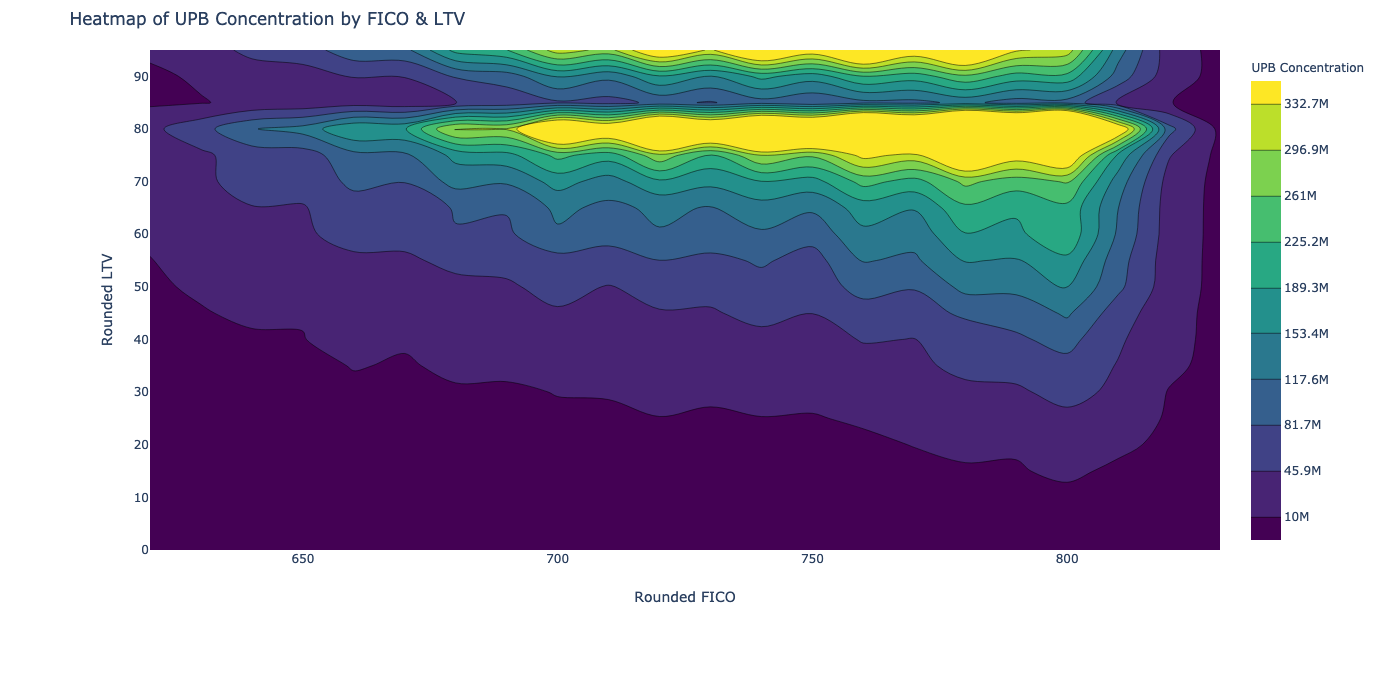

In [21]:
# output the interactive figure in the notebook
iplot(heatmap_ltv_fico_upb_conct_fig)

In [22]:
# saves out the html version of the heatmap
plot(
    figure_or_data = heatmap_ltv_fico_upb_conct_fig, 
    filename="../media/heatmap_ltv_fico_upb_conct_fig.html", 
    auto_open=False
);

# Hope You Enjoyed!

It's my hope that over the course of this seminar (or just by reading these materials) you picked up some fresh insights into the theory and techniques behind practical data visualization. If you're looking for more material, check out the homework in this repository, and feel free to reach out with any feedback! 

Thank you, and happy visualizing!

Work Left To-Do:

- integrate additions from Roland
- slides? (maybe)